In [1]:
import numpy as np
#import numba
import seaborn as sns
import pandas
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize

datadir = "/Users/billiemeadowcroft/Dropbox/PhDGithub/RemoteDumbbells/Data_and_Figures/Fig_TensionTime/Data/"
plotsdir = '/Users/billiemeadowcroft/Dropbox/PhDGithub/RemoteDumbbells/Data_and_Figures/Fig_TensionTime/Plots/'

In [2]:
def tsph(Rsph,Rcyl,W,sigma,kappa,eta):
    v_sig = sigma/(Rsph*eta)
    v_up = W/(Rsph*eta) - (2*kappa)/(Rsph*Rsph*Rsph*eta)
    SqrtFact = np.sqrt(1-(2*v_sig/v_up))
    TanFact = (1/2)*(np.pi/2 + np.arccos(Rcyl/Rsph))
    t = (2/(v_up*SqrtFact))*np.arctan(SqrtFact*np.tan(TanFact))
    
    return t

def tcyl(Rcyl,l,W,sigma,kappa,eta):
    v_up = W/eta - sigma/eta - kappa/(2*eta*Rcyl*Rcyl)
    t = l/v_up
    
    return t


In [3]:
def FindPdiff(rat,init):
    Number = 45130
    No_OUT = Number * init
    No_IN = rat*No_OUT/41.8 #41.8 is how many OUT:IN we have when rat = 1
    Vin_cell  = 6326 #in sigma
    Vbox_nocell = 265621 #in sigma
    pIN = No_IN/Vin_cell #in number/volume(sigma)
    pOUT = No_OUT/Vbox_nocell 
    Difference = pIN-pOUT
    return Difference #/sigma^3 for real units?

#real units when sigma = 10nm, Temp (=1 in lj) = epsilon = 4.34kT?, 

def RealUnits(press):
    T = 4.34 #related to epsilon
    sigma = 10**-6 #our simulation length unit matched to their dumbbell in [m]
    sigmaCube = sigma*sigma*sigma #apparently sigma = 10^-7 (if d = 7.5, their d = 1 micron)
    Pressure = T*press/(72.46) #N/m^2 (72.46 = sigma^3/kB)
    #PressureV2 = T*press/sigmaCube 
    r = 17*sigma
    Tension1 = Pressure*r/4
    #Tension1 = Pressure*1.7*(10**-6)/2 #N/m
    #Tension1V2 = PressureV2*1.7*(10**-6)/2 #N/m (1.7*10^-6 = R in m)
    Tension2 = Tension1*10**9 #nN/(m)
    #Tension2V2 = Tension1V2*10**-9 #N/(nm)
    
    return Tension2, 5 #nN/m, us

PARAMETERS

In [4]:
Rsph = 0.0000005 #meter
Rcyl = Rsph/20 #meter
L = Rsph/10 #meter
kappa = 8.0868E-20 #Joules
sigma0 = 1E-9 #N/m
eta0 = 0.4 #PaS  eta_water = 0.001 (=100*eta_water)
W0 = 0.00000069 #J/m^2 (=1*microJ/m^2)

ExpTime = [9.41667,15.21667,16.23333,24.5,100,170]
ExpTen=[5,6,6,9,15,51]
ExpTenUnits = [5E-9,6E-9,6E-9,9E-9,15E-9,51E-9]
xerr= [14,10,14,20,12,5]
yerr = [2,2,2,2,2,2]
Joule = 4.1E-21

NT = 100
NW = 8
NE = 10
W = 0.00000070
sigma = sigma0*50
DeltaE_1spher = -4*np.pi*(Rsph*Rsph)*W*1.2/Joule + 8*np.pi*20 + 4*np.pi*(Rsph*Rsph)*sigma/Joule
print(DeltaE_1spher)
tauWait = 600
tauWrap = 50
PreFactor = tauWrap/np.exp(DeltaE_1spher)
print(PreFactor)
Ebarrier = np.log(tauWait/PreFactor)
print(Ebarrier)
PreFactor*np.exp(-193)

print("Log(tauwait/tauwrap)",np.log(tauWait/tauWrap),"=Barrier difference between lobe and wrapping")

-102.67644282464194
1.9533611439645704e+46
-100.19153617485394
Log(tauwait/tauwrap) 2.4849066497880004 =Barrier difference between lobe and wrapping


finding sum of standard \chi^2 = sum((yi-ci/(stdi))^2)

/var/folders/wt/4tgp65891vd4l6wskkxdnvk40000gn/T/ipykernel_16318/1428981032.py:4: RuntimeWarning: invalid value encountered in sqrt
  SqrtFact = np.sqrt(1-(2*v_sig/v_up))


Text(0.5, 15.0, 'Effective viscosity $\\eta_{\\mathrm{eff}}$ [PaS]')

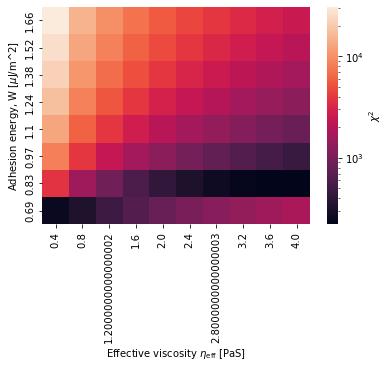

In [5]:
chiSquared = np.zeros((NW,NE))
Ws = []
etas = []
for j in range(NW):
    W = W0+W0*j/5
    Ws.append(W)
    
    for k in range(NE):
        chiSq= 0
        eta = eta0+eta0*k
        if j==0:
            etas.append(eta)
        for ii in range(len(ExpTime)):
            UptakeTime = tcyl(Rcyl,L,W,ExpTenUnits[ii],kappa,eta)+ 2*tsph(Rsph,Rcyl,W,ExpTenUnits[ii],kappa,eta)
            if UptakeTime==UptakeTime:
                chiSq+=((ExpTime[ii]-UptakeTime)**2/(UptakeTime))
            else: 
                chiSq+=((ExpTime[ii])**2/(ExpTime[ii]))
            #if chiSq !=chiSq:
            #    print(eta,W,ii)
        chiSquared[j,k] = chiSq
        
Ws_ = np.round(np.multiply(Ws,1E6),2) #in micro J/m^2
fig3,ax3 = plt.subplots()
sns.heatmap(chiSquared,xticklabels=etas,yticklabels=Ws_,ax=ax3,norm=LogNorm(),cbar_kws={'label': r'$\chi^{2}$'})
ax3.invert_yaxis()
#n = 2  # Keeps every 2nd label\n",
#[l.set_visible(False) for (i,l) in enumerate(ax3.xaxis.get_ticklabels()) if i % n != 0]
#[l.set_visible(False) for (i,l) in enumerate(ax3.yaxis.get_ticklabels()) if i % n != 0]
ax3.set_ylabel(r"Adhesion energy, W [$\mu$J/m^2]")
ax3.set_xlabel(r"Effective viscosity $\eta_{\mathrm{eff}}$ [PaS]")

In [6]:
TimeTens = np.zeros((NT,NW,NE))
Tens = []
Ws = []
etas = []
for i in range(NT):
    sigma = -sigma0/10 + sigma0*(i*2/3+1)
    Tens.append(sigma)
    for j in range(NW):
        W = W0+W0*j/20
        if i ==0 :
            Ws.append(W)
        for k in range(NE):
            eta = eta0+eta0*k
            if i ==0 and j ==0:
                etas.append(eta)
        
            UptakeTime = tcyl(Rcyl,L,W,sigma,kappa,eta)+ 2*tsph(Rsph,Rcyl,W,sigma,kappa,eta)
            if UptakeTime > 0:
                TimeTens[i,j,k] = UptakeTime
            else:
                TimeTens[i,j,k] = None
Ws_ = np.round(np.multiply(Ws,1E6),2) #in micro J/m^2
Tens_ = np.round(np.multiply(Tens,1E9),2) #in nN/m

/var/folders/wt/4tgp65891vd4l6wskkxdnvk40000gn/T/ipykernel_16318/1428981032.py:4: RuntimeWarning: invalid value encountered in sqrt
  SqrtFact = np.sqrt(1-(2*v_sig/v_up))


In [7]:
Size = "5.0 7.5".split()
Eps = "8 5".split()
#Rat = "0.000 0.500 1.000 2.000 3.000".split()
Rat = "0.250 0.500 0.750 1.000 1.250 1.750 2.000 2.250 2.750 3.000".split()
wrapEngulfed = "5.9 2.9".split()

AvSpeed = np.zeros((len(Size),len(Rat)))
AvSpeed_ = np.zeros((len(Size),len(Rat)))
AvStartNom = np.zeros((len(Size),len(Rat)))
STDSpeed = np.zeros((len(Size),len(Rat)))
AvSimLength = np.zeros((len(Size),len(Rat)))

for l in range(len(Size)):
    for k in range(len(Rat)):
        Speeds = []
        for i in range(30):
            #print(StartNom)
            StartNom = []
            count = 0
            wrapN1 = pandas.read_csv(datadir + "WrappingInitRatMass30/wrapping_"+Eps[l]+"_"+Size[l]+"_init_0.050_rat_"+str(Rat[k])+"_seed_"+str(i+1)+".dat", header = None, sep=' ')[1]
            wrapN2 = pandas.read_csv(datadir + "WrappingInitRatMass30_2/wrapping_"+Eps[l]+"_"+Size[l]+"_init_0.050_rat_"+str(Rat[k])+"_seed_"+str(i+1)+".dat", header = None, sep=' ')[1]
            wrapN = np.append(wrapN1,wrapN2)
            if len(wrapN) >4:
                for j in range(len(wrapN)):
                    if j == 0:
                        StartNom.append(wrapN[j])
                    R = Size[l]
                    denom = float(R)**2
                    wrap_rescaled = np.divide(wrapN[j],denom)
                    wrapEng = wrapEngulfed[l]
                    if wrap_rescaled > float(wrapEng) and count == 0:
                        count = 1
                        timeToWrap = j
                    if count == 0 and j == len(wrapN)-1:
                        timeToWrap = None
                Speeds.append(timeToWrap)
        AvStartNom[l][k]=np.mean([x for x in StartNom if x != None])
        AvSpeed_[l][k]=np.mean([x for x in Speeds if x != None])
        AvSpeed[l][k] = AvSpeed_[l][k]-AvStartNom[l][k]
        STDSpeed[l][k] = np.std([x for x in Speeds if x != None])/(np.sqrt(len([x for x in Speeds if x != None])))
x =np.zeros((len(Size),len(Rat)))
ten =np.zeros((len(Size),len(Rat)))
Init = "0.05".split() #"0.000 0.050 0.100 0.150 0.200 0.250 0.300".split()
for i in range(len(Init)):
    for j in range(len(Rat)):
        x[i][j] = FindPdiff(float(Rat[j]),float(Init[i]))
        
for i in range(len(Init)):
    for j in range(len(Rat)):
        ten[i][j] = RealUnits(x[i][j])[0]

/Users/billiemeadowcroft/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/billiemeadowcroft/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/billiemeadowcroft/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/billiemeadowcroft/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/billiemeadowcroft/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


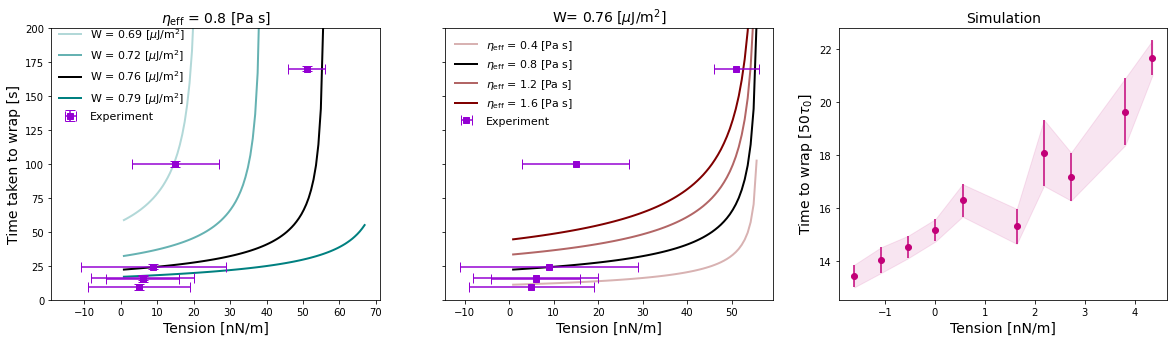

In [8]:
clrs = ["teal","mediumseagreen", "tab:green", "teal", "tab:pink","darkviolet"]
clrs2 = ["lightcoral", "firebrick", "maroon"]


etas_ = np.round(etas,2)
fig,ax = plt.subplots(1,3,figsize = (20,5))
ax[0].plot(Tens_, TimeTens[:,0,1],color = clrs[0],linestyle = '-', marker = '',alpha = 0.3, linewidth = 2,label = r'W = '+str(Ws_[0])+' [$\mu$J/$\mathrm{m}^{2}$]')
ax[0].plot(Tens_, TimeTens[:,1,1],color = clrs[0],linestyle = '-', marker = '',alpha = 0.6,  linewidth = 2, label = r'W = '+str(Ws_[1])+' [$\mu$J/$\mathrm{m}^{2}$]')
ax[0].plot(Tens_, TimeTens[:,2,1],color ='black',linestyle = '-', marker = '', linewidth = 2, label = r'W = '+str(Ws_[2])+' [$\mu$J/$\mathrm{m}^{2}$]')
ax[0].plot(Tens_, TimeTens[:,3,1],color = clrs[0],linestyle = '-', marker = '',alpha = 1,  linewidth = 2, label = r'W = '+str(Ws_[3])+' [$\mu$J/$\mathrm{m}^{2}$]')
ax[0].set_title(r'$\eta_{\mathrm{eff}}$ = '+str(etas_[1])+' [Pa$\ $s]', fontsize = 14)
ax[0].errorbar(ExpTen, ExpTime, xerr = xerr,yerr= yerr,color = clrs[5],capsize = 5,linestyle = ' ', marker = 's', label = r'Experiment')
ax[0].legend(frameon=False, loc = [0.01,0.64],fontsize = 11)
ax[0].set_xlim([-19,71])
ax[0].set_xlabel("Tension [nN/m]", fontsize = 14)
ax[0].set_ylabel("Time taken to wrap [s]", fontsize = 14)
ax[1].set_ylim([0,200])
ax[0].set_ylim([0,200])

#fig2,ax2 = plt.subplots()
ax[1].plot(Tens_, TimeTens[:,2,0],color = clrs2[2],linestyle = '-', marker = '',alpha = 0.3, linewidth = 2, label = r'$\eta_{\mathrm{eff}}$ = '+str(etas_[0])+' [Pa$\ $s]')
ax[1].plot(Tens_, TimeTens[:,2,1],color = 'black',linestyle = '-', marker = '', linewidth = 2, label = r'$\eta_{\mathrm{eff}}$ = '+str(etas_[1])+' [Pa$\ $s]')
ax[1].plot(Tens_, TimeTens[:,2,2],color = clrs2[2],linestyle = '-', marker = '',alpha = 0.6, linewidth = 2, label = r'$\eta_{\mathrm{eff}}$ = '+str(etas_[2])+' [Pa$\ $s]')
ax[1].plot(Tens_, TimeTens[:,2,3],color = clrs2[2],linestyle = '-', marker = '',alpha = 1, linewidth = 2, label = r'$\eta_{\mathrm{eff}}$ = '+str(etas_[3])+' [Pa$\ $s]')
ax[1].errorbar(ExpTen, ExpTime, xerr = xerr,color = clrs[5],capsize = 5,linestyle = '', marker = 's', label = r'Experiment')
#ax2.set_ylim([0,200])
ax[1].set_yticklabels([])
ax[1].set_title('W= '+str(Ws_[2])+' [$\mu$J/$\mathrm{m}^{2}$]', fontsize = 14)
ax[1].legend(frameon=False,fontsize = 11)
ax[1].set_xlabel("Tension [nN/m]", fontsize = 14)
ax[2].set_title("Simulation", fontsize = 14)
#ax[2].scatter(ten[0],AvSpeed[1],color = '#c20078',marker='.', s = 100, label='Dumbbell size 75nm, epsilon 5')
ax[2].errorbar(ten[0],AvSpeed[1]/10,yerr = STDSpeed[1]/10,capsize = 0,marker = 'o',linestyle = '',color = '#c20078', label='Dumbbell size 75nm, epsilon 5')
#ax[2].plot([-1.5,5],[135,220],linestyle = ':',alpha = 0.6,color = '#c20078')
ax[2].fill_between(ten[0],np.add(AvSpeed[1]/10,STDSpeed[1]/10), np.add(AvSpeed[1]/10,-STDSpeed[1]/10), color = '#c20078', alpha=0.1 )
ax[2].set_xlabel(r"Tension [nN/m]", fontsize = 14)
ax[2].set_ylabel(r"Time to wrap [50$\tau_{0}$]", fontsize = 14)

fname = "TimeVsTension.pdf"
fig.savefig(plotsdir+fname)


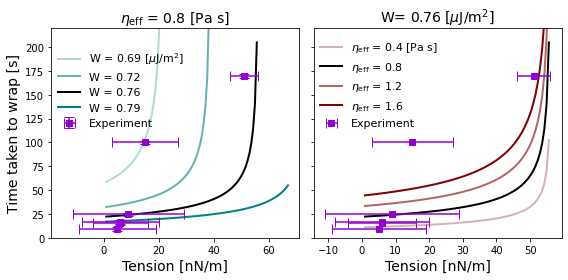

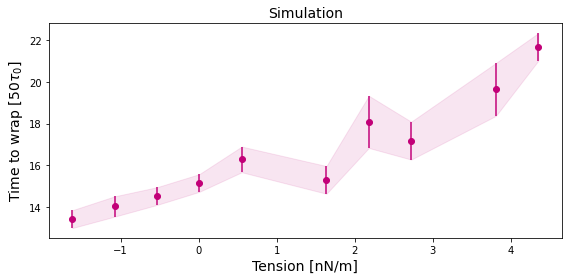

In [18]:
clrs = ["teal","mediumseagreen", "tab:green", "teal", "tab:pink","darkviolet"]
clrs2 = ["lightcoral", "firebrick", "maroon"]


etas_ = np.round(etas,2)
fig,ax = plt.subplots(1,2,figsize = (8,4))
fig2,ax2 = plt.subplots(figsize = (8,4))
ax[0].plot(Tens_, TimeTens[:,0,1],color = clrs[0],linestyle = '-', marker = '',alpha = 0.3, linewidth = 2,label = r'W = '+str(Ws_[0])+' [$\mu$J/$\mathrm{m}^{2}$]')
ax[0].plot(Tens_, TimeTens[:,1,1],color = clrs[0],linestyle = '-', marker = '',alpha = 0.6,  linewidth = 2, label = r'W = '+str(Ws_[1]))
ax[0].plot(Tens_, TimeTens[:,2,1],color ='black',linestyle = '-', marker = '', linewidth = 2, label = r'W = '+str(Ws_[2]))
ax[0].plot(Tens_, TimeTens[:,3,1],color = clrs[0],linestyle = '-', marker = '',alpha = 1,  linewidth = 2, label = r'W = '+str(Ws_[3]))
ax[0].set_title(r'$\eta_{\mathrm{eff}}$ = '+str(etas_[1])+' [Pa$\ $s]', fontsize = 14)
ax[0].errorbar(ExpTen, ExpTime, xerr = xerr,yerr= yerr,color = clrs[5],capsize = 5,linestyle = ' ', marker = 's', label = r'Experiment')
ax[0].legend(frameon=False, loc = [0.01,0.5],fontsize = 11)
ax[0].set_xlim([-19,71])
ax[0].set_xlabel("Tension [nN/m]", fontsize = 14)
ax[0].set_ylabel("Time taken to wrap [s]", fontsize = 14)
ax[1].set_ylim([0,220])
ax[0].set_ylim([0,220])

#fig2,ax2 = plt.subplots()
ax[1].plot(Tens_, TimeTens[:,2,0],color = clrs2[2],linestyle = '-', marker = '',alpha = 0.3, linewidth = 2, label = r'$\eta_{\mathrm{eff}}$ = '+str(etas_[0])+' [Pa$\ $s]')
ax[1].plot(Tens_, TimeTens[:,2,1],color = 'black',linestyle = '-', marker = '', linewidth = 2, label = r'$\eta_{\mathrm{eff}}$ = '+str(etas_[1]))
ax[1].plot(Tens_, TimeTens[:,2,2],color = clrs2[2],linestyle = '-', marker = '',alpha = 0.6, linewidth = 2, label = r'$\eta_{\mathrm{eff}}$ = '+str(etas_[2]))
ax[1].plot(Tens_, TimeTens[:,2,3],color = clrs2[2],linestyle = '-', marker = '',alpha = 1, linewidth = 2, label = r'$\eta_{\mathrm{eff}}$ = '+str(etas_[3]))
ax[1].errorbar(ExpTen, ExpTime, xerr = xerr,color = clrs[5],capsize = 5,linestyle = '', marker = 's', label = r'Experiment')
#ax2.set_ylim([0,200])
ax[1].set_yticklabels([])
ax[1].set_title('W= '+str(Ws_[2])+' [$\mu$J/$\mathrm{m}^{2}$]', fontsize = 14)
ax[1].legend(frameon=False,fontsize = 11,loc = [0.01,0.5])
ax[1].set_xlabel("Tension [nN/m]", fontsize = 14)


fig.tight_layout()
ax2.set_title("Simulation", fontsize = 14)
#ax[2].scatter(ten[0],AvSpeed[1],color = '#c20078',marker='.', s = 100, label='Dumbbell size 75nm, epsilon 5')
ax2.errorbar(ten[0],AvSpeed[1]/10,yerr = STDSpeed[1]/10,capsize = 0,marker = 'o',linestyle = '',color = '#c20078', label='Dumbbell size 75nm, epsilon 5')
#ax[2].plot([-1.5,5],[135,220],linestyle = ':',alpha = 0.6,color = '#c20078')
ax2.fill_between(ten[0],np.add(AvSpeed[1]/10,STDSpeed[1]/10), np.add(AvSpeed[1]/10,-STDSpeed[1]/10), color = '#c20078', alpha=0.1 )
ax2.set_xlabel(r"Tension [nN/m]", fontsize = 14)
ax2.set_ylabel(r"Time to wrap [50$\tau_{0}$]", fontsize = 14)
fig2.tight_layout()
fname2 = "TimeVsTensionSimulation.pdf"
fig2.savefig(plotsdir+fname2)

fname = "TimeVsTensionTheory.pdf"
fig.savefig(plotsdir+fname)